In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from scipy.stats import gamma
from scipy.signal import convolve
from math import ceil

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim

import nibabel as nib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)



class ModelBOLD

Convolved BOLD Signal (y_conv): Should display peaks corresponding to the event onsets, shaped by the HRF.

Alignment Time (alignment_ts): Should show the same BOLD signal shifted forward by the specified hemodynamic delay, aligning the peak of the BOLD response with the appropriate neural event.

In [4]:
def visualize_data(first_data_x, first_data_y, participant_id, run_id):
    # Reshape X for plotting
    X_features = first_data_x.reshape(first_data_x.shape[0], -1)
    
    # Print shapes and data types
    print(f"X shape: {first_data_x.shape}, X dtype: {first_data_x.dtype}")
    print(f"y shape: {first_data_y.shape}, y dtype: {first_data_y.dtype}")
    
    # Display sample values
    print("\nSample values from X (first 5 time points):")
    print(first_data_x[:5])
    print("\nSample values from y (first 5 time points):")
    print(first_data_y[:5])
    
    # Plot voxel time series
    X_features = first_data_x.reshape(first_data_x.shape[0], -1)  # Make sure the shape is (time_points, num_voxels)
    plt.figure(figsize=(15, 10))  
    for voxel_idx in range(X_features.shape[1]):
        plt.plot(X_features[:, voxel_idx], label=f'Voxel {voxel_idx}')

    plt.title(f'All Voxel Time Series for {participant_id} {run_id}')
    plt.xlabel('Time Points')
    plt.ylabel('Voxel Intensity')
    plt.show()
    
    # Summary statistics
    y_values = first_data_y.flatten()
    voxel_columns = [f'voxel_{i}' for i in range(X_features.shape[1])]
    X_df = pd.DataFrame(X_features, columns=voxel_columns)
    X_df['y'] = y_values
    print("\nSummary Statistics of Voxel Features:")
    print(X_df.describe())
    
    # Correlation plot
    corr_matrix = X_df.corr()
    voxel_y_corr = corr_matrix['y'].drop('y')
    plt.figure(figsize=(12, 6))
    voxel_y_corr.plot(kind='bar')
    plt.title(f'Correlation Between Voxel Features and y for {participant_id} {run_id}')
    plt.xlabel('Voxel Features')
    plt.ylabel('Correlation Coefficient')
    plt.show()


In [5]:
class ModelBOLD:
    @staticmethod
    def hrf(tr, duration=32.0):
        """
        Create a canonical Hemodynamic Response Function (HRF) using a double-gamma model.

        Args:
            tr (float): Repetition time (seconds).
            duration (float): Duration to model the HRF (seconds).

        Returns:
            hrf (numpy.ndarray): The HRF sampled at TR intervals.
        """
        # Parameters for the double-gamma HRF
        peak1 = 6
        undershoot = 16
        dispersion1 = 1
        dispersion2 = 1
        ratio = 6
        scale = 1

        t = np.linspace(0, duration, int(duration / tr))
        hrf = (gamma.pdf(t, peak1 / dispersion1, scale=dispersion1) -
               gamma.pdf(t, undershoot / dispersion2, scale=dispersion2) / ratio)
        hrf = hrf / np.max(hrf)  # Normalize
        return hrf

    @staticmethod
    def convolve_events_with_hrf(event_onsets, tr=1.5, duration=32.0, hemodynamic_delay=7.5):
        """
        Convolve event onsets with HRF and apply hemodynamic delay.

        Args:
            event_onsets (numpy.ndarray): Array of event onset times in seconds.
            tr (float): Repetition time (seconds).
            duration (float): Duration to model the HRF (seconds).
            hemodynamic_delay (float): Hemodynamic delay in seconds.

        Returns:
            y_conv (numpy.ndarray): The convolved and delayed BOLD signal.
            alignment_ts (numpy.ndarray): Alignment timestamps adjusted for hemodynamic delay.
        """
        # Generate HRF
        hrf = ModelBOLD.hrf(tr=tr, duration=duration)

        # Define total duration
        if len(event_onsets) == 0:
            print("No event onsets provided.")
            return np.array([]), np.array([])
        
        total_duration = event_onsets[-1] + duration
        num_time_points = int(np.ceil(total_duration / tr))
        time_vector = np.arange(0, num_time_points * tr, tr)

        # Create binary event series
        event_series = np.zeros_like(time_vector)
        for onset in event_onsets:
            idx = np.where(time_vector >= onset)[0]
            if len(idx) > 0:
                event_series[idx[0]] = 1  # Mark the first TR >= onset

        # Convolve event series with HRF
        y_conv_full = convolve(event_series, hrf)[:num_time_points]

        # Normalize y_conv
        if np.max(y_conv_full) != 0:
            y_conv = y_conv_full / np.max(y_conv_full)
        else:
            y_conv = y_conv_full

        # Alignment timestamps: align the convolved signal to BOLD data by applying hemodynamic delay
        delay_slices = int(hemodynamic_delay / tr)
        alignment_ts = np.pad(y_conv, (delay_slices, 0), 'constant')[:num_time_points]

        return y_conv, alignment_ts

Note num_slices mean time points (4th dimension of fMRI)

In [12]:
def get_run_prefixes():
    """
    Generate run prefixes for participants s05 and s14.

    Returns:
        list: List of run prefixes.
    """
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 7)]  # s05_run001 to s05_run006
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 7)]  # s14_run002 to s14_run006
    return s05 + s14

def match_files(input_dir, prefixes):
    """
    Match NIfTI files with their corresponding CSV label files.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.

    Returns:
        list of tuples: Each tuple contains paths to a matched NIfTI and CSV file.
    """
    matched = []
    missing_files = {'nifti': [], 'csv': []}
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(input_dir, f"{prefix}_orientations.csv")
        nifti_exists = os.path.isfile(nifti_path)
        csv_exists = os.path.isfile(csv_path)

        if nifti_exists and csv_exists:
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            if not nifti_exists:
                missing_files['nifti'].append(nifti_path)
            if not csv_exists:
                missing_files['csv'].append(csv_path)

    if missing_files['nifti'] or missing_files['csv']:
        print(f"Warning: Missing NIfTI files: {missing_files['nifti']}")
        print(f"Warning: Missing CSV files: {missing_files['csv']}")

    return matched

def get_measurement_df(nifti_path, csv_path, required_columns, rows_per_slice, delay_rows, voxel_indices=None):
    """
    Load and process voxel and event data, applying hemodynamic delay.

    Args:
        nifti_path (str): Path to the NIfTI file.
        csv_path (str): Path to the CSV file.
        required_columns (set): Required columns in the CSV.
        rows_per_slice (int): Number of CSV rows per NIfTI slice.
        delay_rows (int): Number of rows to delay for hemodynamic alignment.
        voxel_indices (list of tuples, optional): Specific voxels to extract.

    Returns:
        tuple: (processed DataFrame, list of voxel column names)
    """
    # Load NIfTI data
    try:
        nii_img = nib.load(nifti_path)
        data = nii_img.get_fdata()  # Shape: (X, Y, Z, Time)
        print(f"Loaded NIfTI file: {nifti_path} with shape {data.shape}")
    except Exception as e:
        print(f"Error loading NIfTI file {nifti_path}: {e}")
        return None, []

    # Load CSV event data
    try:
        labels_df = pd.read_csv(csv_path)
        print(f"Loaded CSV file: {csv_path} with {len(labels_df)} entries")
    except Exception as e:
        print(f"Error loading CSV file {csv_path}: {e}")
        return None, []

    # Check for required columns
    if not required_columns.issubset(labels_df.columns):
        missing = required_columns - set(labels_df.columns)
        print(f"Error: Missing required columns {missing} in {csv_path}")
        return None, []

    slice_indices = np.arange(0, data.shape[-1])
    csv_indices = slice_indices * rows_per_slice - delay_rows

    # Ensure indices are within bounds
    valid_mask = (csv_indices >= 0) & (csv_indices < len(labels_df))
    csv_indices = csv_indices[valid_mask].astype(int)
    slice_indices = slice_indices[valid_mask]

    if len(csv_indices) == 0:
        print("Warning: No valid CSV indices after applying delay. Skipping this file.")
        return None, []

    # Extract filtered labels
    filtered_labels = labels_df.iloc[csv_indices][['Time', 'Orientation']].reset_index(drop=True)
    print(f"Filtered labels shape: {filtered_labels.shape}")

    # Extract 'Time' and 'Orientation'
    if 'Time' in required_columns:
        event_onsets = filtered_labels['Time'].astype(float).values  # Ensure 'Time' is float
    if 'Orientation' in required_columns:
        orientations = filtered_labels['Orientation'].values

    # Extract voxel data at slice_indices
    extracted_data = data[..., slice_indices]  # Shape: (X, Y, Z, num_slices)
    print(f"Extracted voxel data shape: {extracted_data.shape}")

    # Reshape voxel data to (num_slices, voxel_features)
    num_slices = extracted_data.shape[-1]
    voxel_features = extracted_data.transpose(3, 0, 1, 2).reshape(num_slices, -1)  # Shape: (num_slices, voxel_features)
    print(f"Reshaped voxel features to shape: {voxel_features.shape}")

    # Identify voxels that are zero across all time points
    non_zero_voxel_mask = np.any(voxel_features != 0, axis=0)
    # Filter out zero-only voxels
    voxel_features = voxel_features[:, non_zero_voxel_mask]
    print(f"Voxel features shape after removing zero voxels: {voxel_features.shape}")

    # PCA, select top 1000 most variable voxels
    if voxel_indices is None:
        variances = np.var(voxel_features, axis=0)
        top_voxel_indices = np.argsort(variances)[-1000:]  # Select top 1000, may end up being less 
        voxel_features = voxel_features[:, top_voxel_indices]
        original_indices = np.where(non_zero_voxel_mask)[0]
        selected_indices = original_indices[top_voxel_indices]
        voxel_list = [f"voxel_{i}" for i in selected_indices]
        print(f"Selected top {len(top_voxel_indices)} most variable voxels based on variance.")
    else:
        # Convert voxel coordinates to flat indices
        X, Y, Z = data.shape[:3]
        flat_indices = [x * Y * Z + y * Z + z for (x, y, z) in voxel_indices]
        voxel_features = voxel_features[:, flat_indices]
        voxel_list = [f"voxel_{x}_{y}_{z}" for (x, y, z) in voxel_indices]
        print(f"Selected {len(voxel_indices)} specified voxels.")

    # Scale voxel features
    scaler = MinMaxScaler()
    voxel_features_scaled = scaler.fit_transform(voxel_features)
    print(f"Scaled voxel features with MinMaxScaler.")

    # Create voxel DataFrame
    voxel_df = pd.DataFrame(voxel_features_scaled, columns=voxel_list)
    voxel_df['Time_Point'] = slice_indices
    print(f"Voxel Slice Indices DataFrame shape: {voxel_df.shape}")

    # Optionally, print the first few rows to see the new DataFrame structure
    # print(voxel_df.head())

    # Combine voxel data with event data
    df = pd.concat([filtered_labels, voxel_df], axis=1)
    print(f"Combined (Time  Orientation  Voxels  Slice Indices) DataFrame shape: {df.shape}")
    print(df)

    return df, voxel_list


CLASSIFICATION

Matched: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run001.nii <--> C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run001_orientations.csv
Matched: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run002.nii <--> C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run002_orientations.csv
Matched: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run003.nii <--> C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run003_orientations.csv
Matched: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR\s05_run004.nii <--> C:

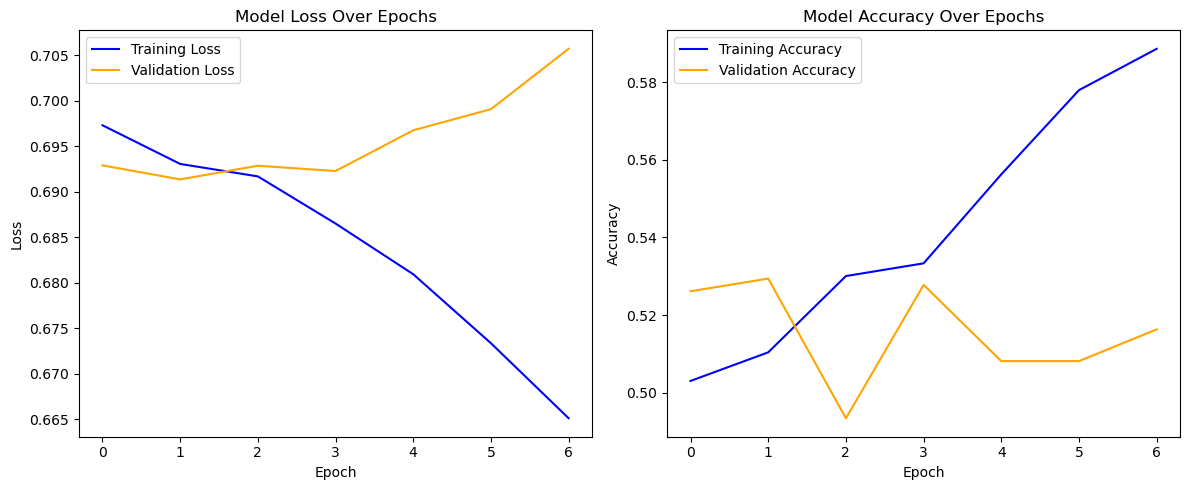

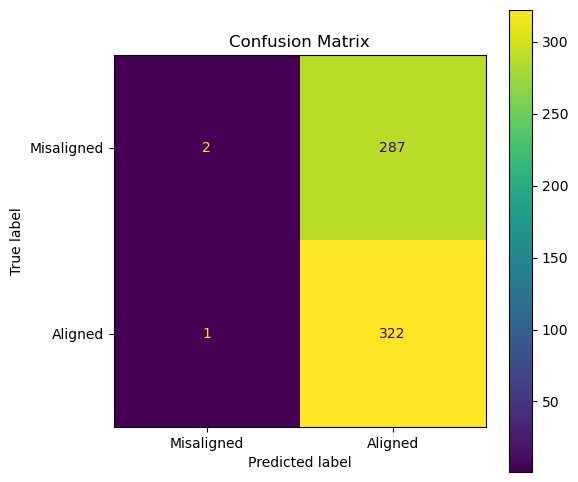

Classification Report:
              precision    recall  f1-score   support

  Misaligned       0.67      0.01      0.01       289
     Aligned       0.53      1.00      0.69       323

    accuracy                           0.53       612
   macro avg       0.60      0.50      0.35       612
weighted avg       0.59      0.53      0.37       612



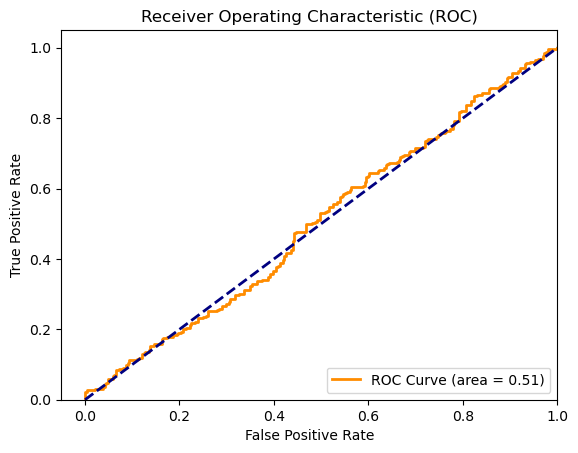

Dataset for s05 run004 - X shape: (346, 96, 1), y shape: (346,)
X shape: (346, 96, 1), X dtype: float32
y shape: (346,), y dtype: int32

Sample values from X (first 5 time points):
[[[0.8507099 ]
  [0.6010426 ]
  [0.8469242 ]
  [0.750087  ]
  [0.59355265]
  [0.6327125 ]
  [0.79183954]
  [0.73387694]
  [0.4326488 ]
  [0.78305084]
  [0.45757577]
  [0.5750161 ]
  [0.51091826]
  [0.5915879 ]
  [0.94747543]
  [0.8433777 ]
  [0.51987046]
  [0.58331096]
  [0.48482934]
  [0.8718626 ]
  [0.4755043 ]
  [0.65219826]
  [0.4714567 ]
  [0.87921846]
  [0.57306415]
  [0.54510766]
  [0.49212703]
  [0.6869633 ]
  [0.44568738]
  [0.4952741 ]
  [0.70543617]
  [0.5109388 ]
  [0.4       ]
  [0.37578452]
  [0.67005074]
  [0.59106433]
  [0.5242851 ]
  [0.46312365]
  [0.6395838 ]
  [0.43333334]
  [0.54847646]
  [0.50675523]
  [0.868257  ]
  [0.8586226 ]
  [0.5       ]
  [0.70438975]
  [0.72893596]
  [0.8799588 ]
  [0.41868824]
  [0.74390864]
  [0.8195383 ]
  [0.37680438]
  [0.76427704]
  [0.8827086 ]
  [0.6572

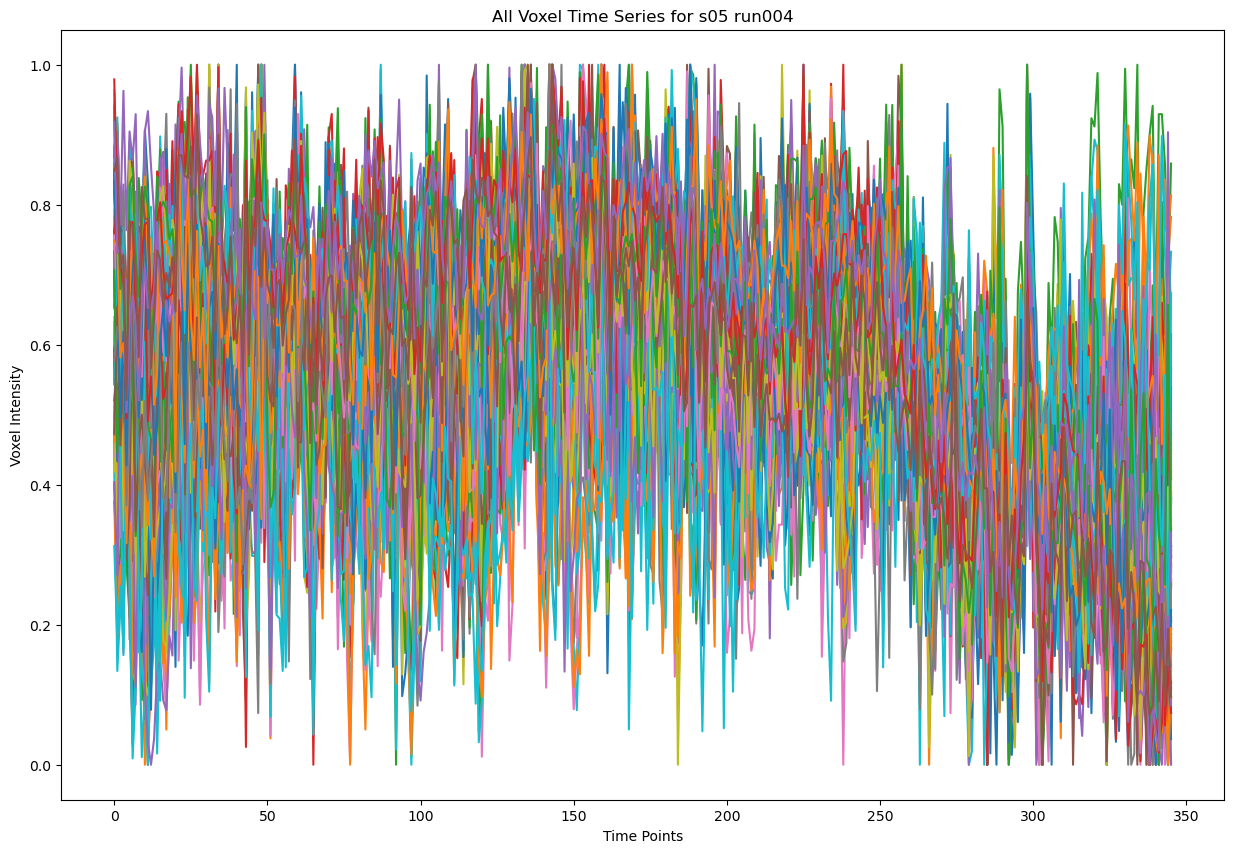


Summary Statistics of Voxel Features:
          voxel_0     voxel_1     voxel_2     voxel_3     voxel_4     voxel_5  \
count  346.000000  346.000000  346.000000  346.000000  346.000000  346.000000   
mean     0.543696    0.471390    0.489015    0.521345    0.516225    0.543124   
std      0.183047    0.140511    0.167721    0.168336    0.167831    0.148153   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.417444    0.375038    0.374821    0.420727    0.408026    0.446158   
50%      0.543205    0.467188    0.486051    0.520362    0.516118    0.548021   
75%      0.653550    0.571297    0.604077    0.626610    0.619143    0.644063   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

          voxel_6     voxel_7     voxel_8     voxel_9  ...    voxel_87  \
count  346.000000  346.000000  346.000000  346.000000  ...  346.000000   
mean     0.453239    0.517387    0.513091    0.515942  ...    0.584782   
std      

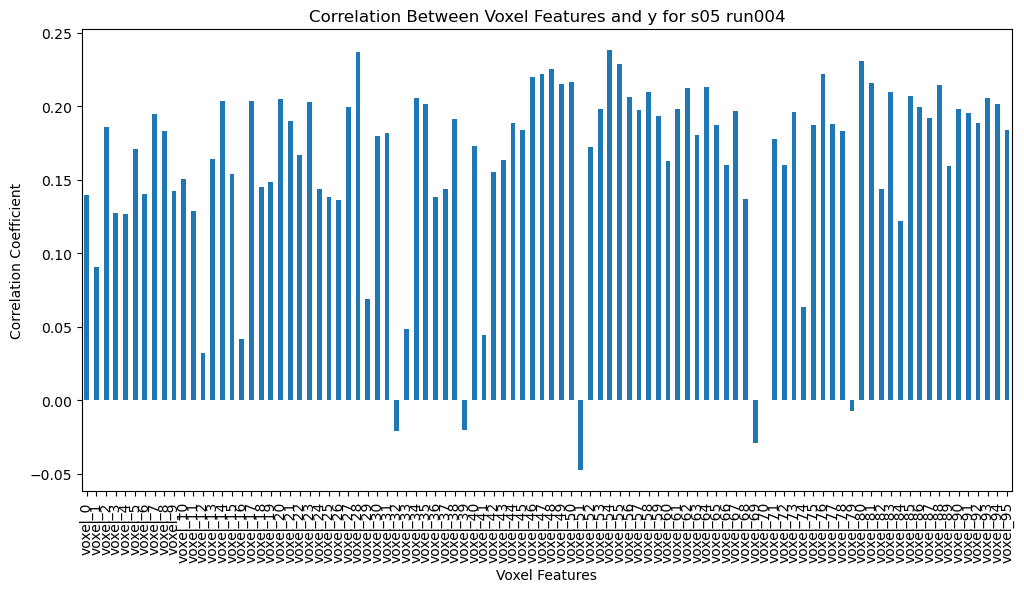


First Labels DataFrame:
   Orientation  Aligned  voxel_3266  voxel_3727  voxel_3748  voxel_2866  \
0      0.00000        1    0.850710    0.601043    0.846924    0.750087   
1     56.34355        1    0.511968    0.446489    0.555436    0.520362   
2     21.94557        0    0.385801    0.368905    0.409871    0.419074   
3     18.42516        0    0.417444    0.398651    0.604077    0.466411   
4     18.42516        0    0.488438    0.386998    0.444564    0.439262   

   voxel_2867  voxel_3686  voxel_3347  voxel_3666  ...  voxel_3265  \
0    0.593553    0.632712    0.791840    0.733877  ...    0.958360   
1    0.535394    0.395227    0.577109    0.460712  ...    0.762395   
2    0.393486    0.440629    0.483402    0.431801  ...    0.633398   
3    0.509472    0.513970    0.429461    0.417346  ...    0.583387   
4    0.406447    0.378347    0.355809    0.431801  ...    0.449882   

   voxel_4167  voxel_3245  voxel_4610  voxel_4589  voxel_4969  voxel_3645  \
0    0.576288    0.963648 

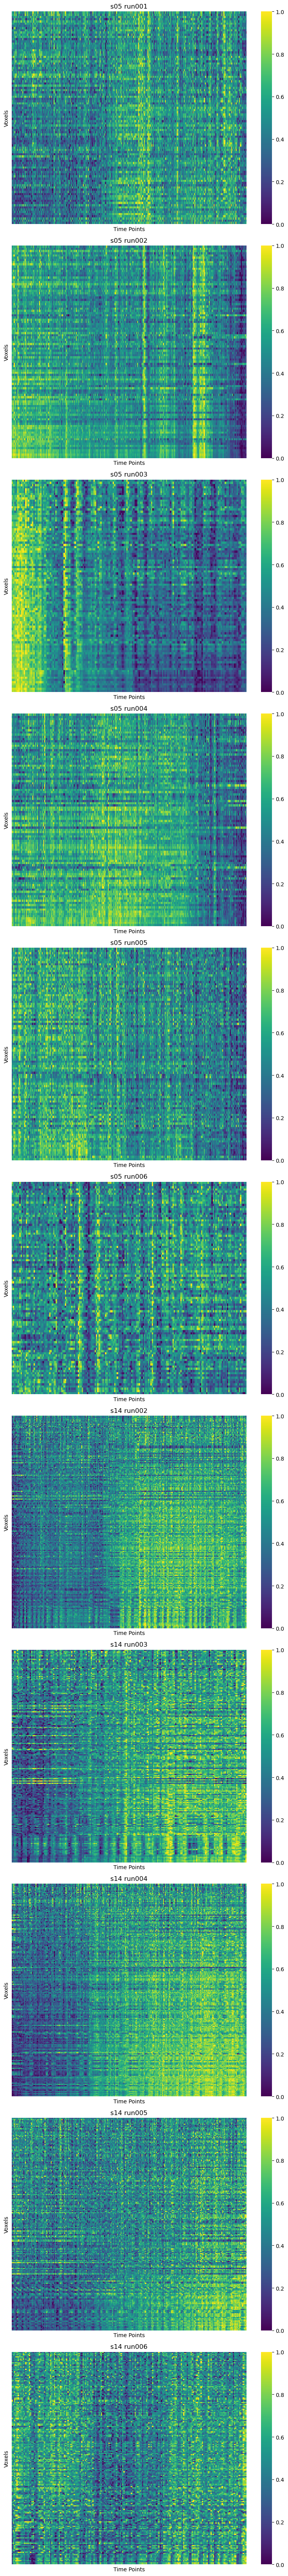

In [16]:
def load_delay_data(input_dir, prefixes, required_columns, voxel_indices=None,
                    seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5):
    """
    Load and process data for multiple file pairs.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.
        required_columns (set): Set of required columns in the CSV files.
        voxel_indices (list of tuples, optional): Specific voxels to extract.
        seconds_per_slice (float): Duration each NIfTI slice represents in seconds.
        rows_per_slice (int): Number of CSV rows corresponding to one NIfTI slice.
        delay_seconds (float): Hemodynamic delay in seconds.

    Returns:
        tuple: (data_x_list, data_y_list, scalers, labels_list)
            - data_x_list: List of feature matrices.
            - data_y_list: List of target vectors.
            - scalers: List of scalers used for voxel features.
            - labels_list: List of DataFrames with orientation labels and voxel data.
    """
    data_x_list = []
    data_y_list = []
    scalers = []
    labels_list = []
    id_list = []

    matched_files = match_files(input_dir, prefixes)
    print(f"\nTotal matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice
    delay_rows = int(delay_seconds / seconds_per_row)
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Extract participant_id and run_id from the prefix
            prefix = os.path.splitext(os.path.basename(nifti_path))[0]
            participant_id, run_id = prefix.split('_')

            # Load and process data
            df, voxel_list = get_measurement_df(
                nifti_path=nifti_path,
                csv_path=csv_path,
                required_columns=required_columns,
                rows_per_slice=rows_per_slice,
                delay_rows=delay_rows,
                voxel_indices=voxel_indices                                     # Ensure voxel_indices is passed here
            )

            if df is None:
                print(f"  Skipping file pair due to previous errors.\n")
                continue

            # Step 1: Create binary labels
            aligned_angles = np.array([0, 60, 120, 180, 240, 300])
            tolerance = 15  # Degrees

            def is_aligned(angle):
                angle_mod = angle % 360
                angle_diff = np.abs(aligned_angles - angle_mod)
                angle_diff = np.minimum(angle_diff, 360 - angle_diff)
                return 1 if np.any(angle_diff <= tolerance) else 0      # Calculation of the minimum absolute difference between the given angle and each aligned angle

            df['Aligned'] = df['Orientation'].apply(is_aligned)         # new column df['Aligned'] that contains 1 (aligned) or 0 (not aligned) for each entry

            # Step 2: Prepare the features
            voxel_list = [col for col in df.columns if col.startswith('voxel_')]
            features = df[voxel_list].values
            scaler_features = MinMaxScaler()                            # Scaling across all datasets
            features_scaled = scaler_features.fit_transform(features)

            # Reshape features for 1D CNN input
            num_samples = features_scaled.shape[0]
            num_voxels = features_scaled.shape[1]
            # features_reshaped = features_scaled.reshape(num_samples, num_voxels, 1)

            desired_num_voxels = 96  # Set to the expected number of voxels

            if features_scaled.shape[1] > desired_num_voxels:
                features_scaled = features_scaled[:, :desired_num_voxels]  # Truncate
            elif features_scaled.shape[1] < desired_num_voxels:
                padded_features = np.zeros((features_scaled.shape[0], desired_num_voxels))
                padded_features[:, :features_scaled.shape[1]] = features_scaled
                features_scaled = padded_features
            # Reshape features for 1D CNN input
            features_reshaped = features_scaled.reshape(num_samples, desired_num_voxels, 1)

            data_x = features_reshaped.astype(np.float32)

            # Step 3: Prepare the labels
            target = df['Aligned'].values.astype(np.int32)
            data_y = target                                             # For binary classification

            # Append to lists
            data_x_list.append(data_x)
            data_y_list.append(data_y)

            # Debugging: Print the shape of each `data_x`
            print(f"Appended data_x shape: {data_x.shape}")

            labels_list.append(df[['Orientation', 'Aligned'] + voxel_list])
            id_list.append((participant_id, run_id))

            # Store the scaler
            scalers.append(scaler_features)

            # Debugging Information
            print(f"  Feature matrix 'data_x' shape: {data_x.shape}")
            print(f"  Target vector 'data_y' shape: {data_y.shape}")
            print(f"  Number of aligned samples: {np.sum(data_y)}")
            print(f"  Number of misaligned samples: {len(data_y) - np.sum(data_y)}\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")

    return data_x_list, data_y_list, scalers, labels_list, id_list

def visualize_combined(y_conv, alignment_ts, mean_bold_signal, participant_id, run_id):
    time_points = np.arange(len(y_conv))

    # Normalize signals for better comparison
    scaler = MinMaxScaler()
    y_conv_norm = scaler.fit_transform(y_conv.reshape(-1, 1)).flatten()
    alignment_ts_norm = scaler.fit_transform(alignment_ts.reshape(-1, 1)).flatten()
    mean_bold_signal_norm = scaler.fit_transform(mean_bold_signal.reshape(-1, 1)).flatten()

    # Create a single plot to display all signals
    plt.figure(figsize=(8, 4))
    plt.plot(time_points, y_conv_norm, label='Convolved Signal (normalized)', color='blue')
    plt.plot(time_points, alignment_ts_norm, label='Alignment Timestamps (normalized)', color='orange')
    plt.plot(time_points, mean_bold_signal_norm, label='Mean BOLD Signal (normalized)', color='green')
    plt.xlabel('Time Points')
    plt.ylabel('Normalized Signal Intensity')
    plt.title(f'Aligned Signals for {participant_id} {run_id}')
    plt.legend()
    plt.show()

def main():
    """
    Main function to execute the data processing workflow.
    """
    # Define the data directory
    # DATA_DIR = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR'      
    DATA_DIR = r'C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\INPUT_DIR'
    # Define required columns in CSV
    prefixes = get_run_prefixes()
    required_columns = {'Orientation', 'Time'}  # Adjust based on your CSV structure

    # Define delay parameters
    seconds_per_slice = 1.5   # Duration each NIfTI slice represents in seconds
    rows_per_slice = 14       # Number of CSV rows corresponding to one NIfTI slice
    delay_seconds = 7.5       # Hemodynamic delay in seconds

    voxel_indices = None  # Set to None to select top 1000 most variable voxels

    # Load and process data
    data_x_list, data_y_list, scalers, labels_list, id_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        voxel_indices=voxel_indices,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds
    )

    # Combine data from all runs
    data_x = np.concatenate(data_x_list, axis=0)
    data_y = np.concatenate(data_y_list, axis=0)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        data_x, data_y, test_size=0.2, random_state=42, stratify=data_y
    )

    #------------------------------------------------------------------------#
    # Define the model
    num_voxels = data_x.shape[1]
    input_shape = (num_voxels, 1)
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Handle class imbalance if necessary
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(data_y),
        y=data_y
    )
    class_weights = dict(enumerate(class_weights))

    from tensorflow.keras.callbacks import EarlyStopping

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    # Train the model and save the history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=10,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

    #------------------------------------------------------------------------#
    # Visualization of Training Results
    # 1. Plot Training and Validation Loss and Accuracy

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 2. Confusion Matrix
    # Predict classes for validation set
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Misaligned', 'Aligned'])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    cmd.plot(ax=ax)
    plt.title('Confusion Matrix')
    plt.show()

    # 3. Classification Report
    print("Classification Report:")
    print(classification_report(y_val, y_pred, target_names=['Misaligned', 'Aligned']))

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    #------------------------------------------------------------------------#
    # Access the first dataset
    if len(data_x_list) > 0:
        first_data_x = data_x_list[3]
        first_data_y = data_y_list[3]
        first_labels = labels_list[3]
        participant_id, run_id = id_list[3]
        print(f"Dataset for {participant_id} {run_id} - X shape: {first_data_x.shape}, y shape: {first_data_y.shape}")

        visualize_data(first_data_x, first_data_y, participant_id, run_id)

        # Display the extended DataFrame
        print("\nFirst Labels DataFrame:")
        print(first_labels.head())
        print(first_labels.describe())

    # Visualization of Individual Runs
    # Ensure that labels_list and id_list have the same length
    if len(labels_list) == len(id_list):
        # Create a directory to save individual run plots
        plot_dir = 'individual_run_plots'
        os.makedirs(plot_dir, exist_ok=True)

        total_runs = len(labels_list)
        cols = 1  
        rows = ceil(total_runs / cols)  
        plt.figure(figsize=(cols * 8, rows * 6))  

        for i in range(total_runs):
            run_df = labels_list[i]
            participant_id, run_id = id_list[i]

            # Extract voxel columns (assuming they start with 'voxel_')
            voxel_columns = [col for col in run_df.columns if col.startswith('voxel_')]
            voxel_data = run_df[voxel_columns].values.T                                         # Shape: (num_voxels, num_time_points)

            # Optional: Limit the number of voxels to display for better visualization
            num_voxels_to_display = 1000
            if voxel_data.shape[0] > num_voxels_to_display:
                voxel_data = voxel_data[:num_voxels_to_display, :]

            plt.subplot(rows, cols, i + 1)  # Define subplot position
            sns.heatmap(voxel_data, cmap='viridis', cbar=True if i % cols == 0 else False, xticklabels=False, yticklabels=False)
            plt.title(f'{participant_id} {run_id}')
            plt.xlabel('Time Points')
            plt.ylabel('Voxels')

        plt.tight_layout()  # Adjust layout to fit everything neatly
        plt.savefig(os.path.join(plot_dir, 'all_runs_heatmaps.png'))  # Save the figure
        plt.show()  # Show the figure
    else:
        print("Mismatch between labels_list and id_list lengths. Cannot plot individual runs.")
    
if __name__ == "__main__":
    main()


REGRESSION

Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run006.ni

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5539 - mae: 0.6631 - mse: 0.5539 - val_loss: 0.5483 - val_mae: 0.6683 - val_mse: 0.5483
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5316 - mae: 0.6550 - mse: 0.5316 - val_loss: 0.5498 - val_mae: 0.6688 - val_mse: 0.5498
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5284 - mae: 0.6518 - mse: 0.5284 - val_loss: 0.5459 - val_mae: 0.6652 - val_mse: 0.5459
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5249 - mae: 0.6484 - mse: 0.5249 - val_loss: 0.5436 - val_mae: 0.6627 - val_mse: 0.5436
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5184 - mae: 0.6423 - mse: 0.5184 - val_loss: 0.5448 - val_mae: 0.6621 - val_mse: 0.5448
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5089 - mae: 0.6360 - mse: 0.5089 - val_loss: 0.5445 - val_mae: 0.6600 - val_mse: 0.5445
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4966 - mae: 0.6268 - mse: 0.4966 - val_loss: 0.5571 - val_mae: 

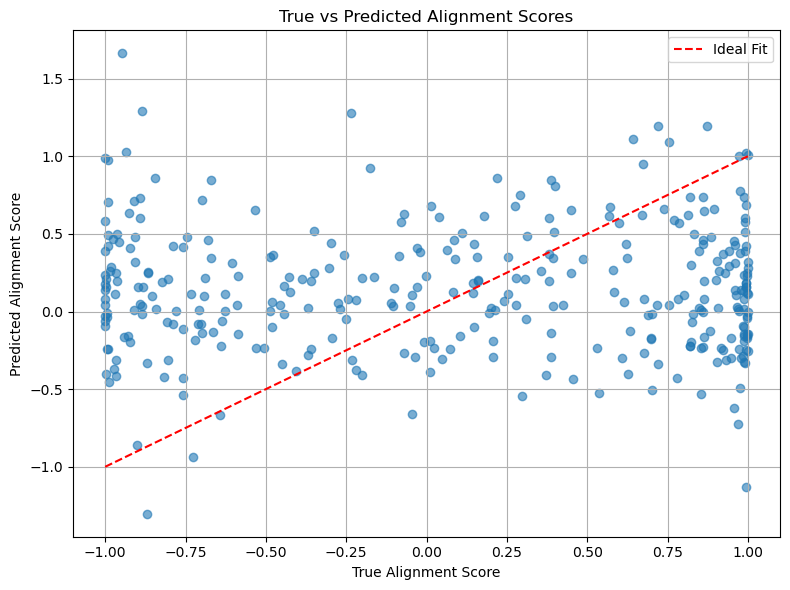

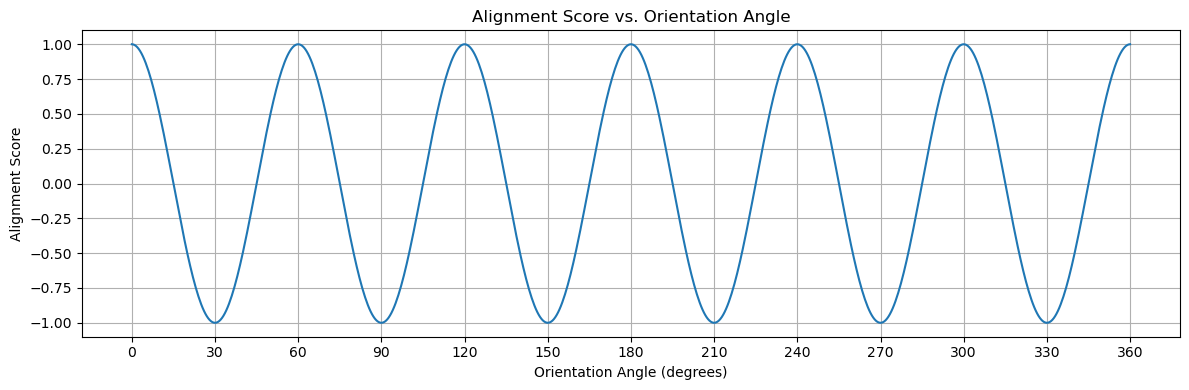

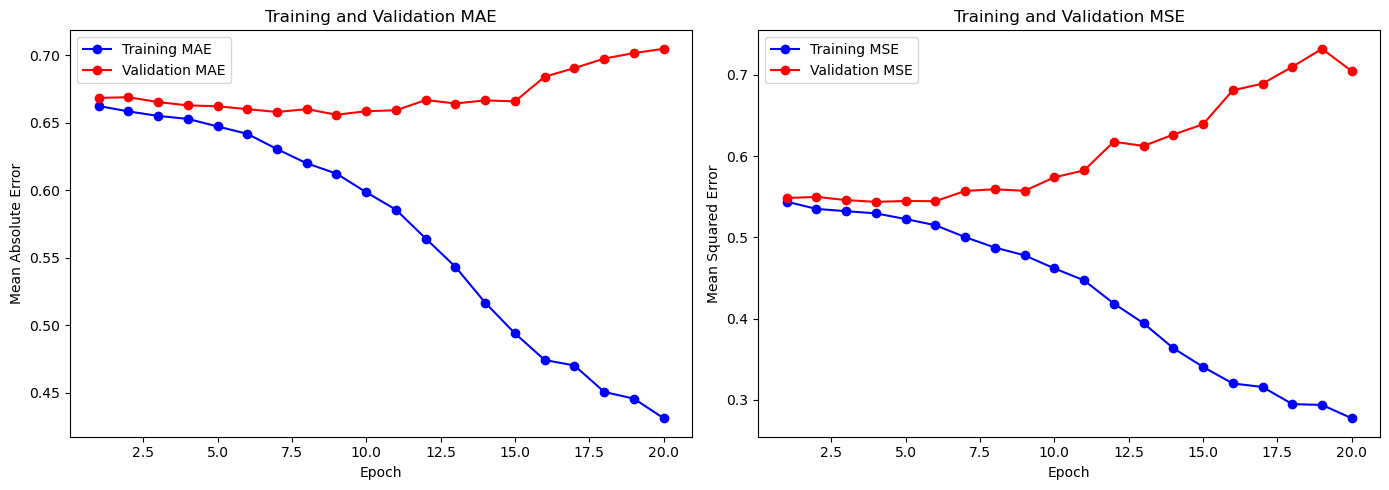

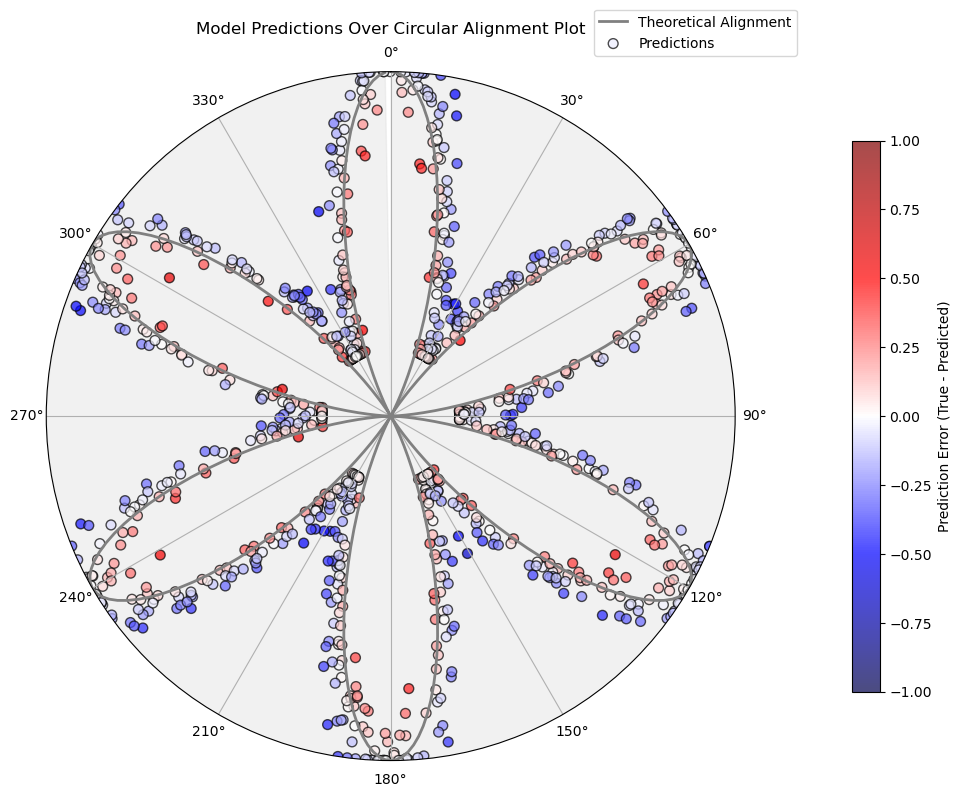

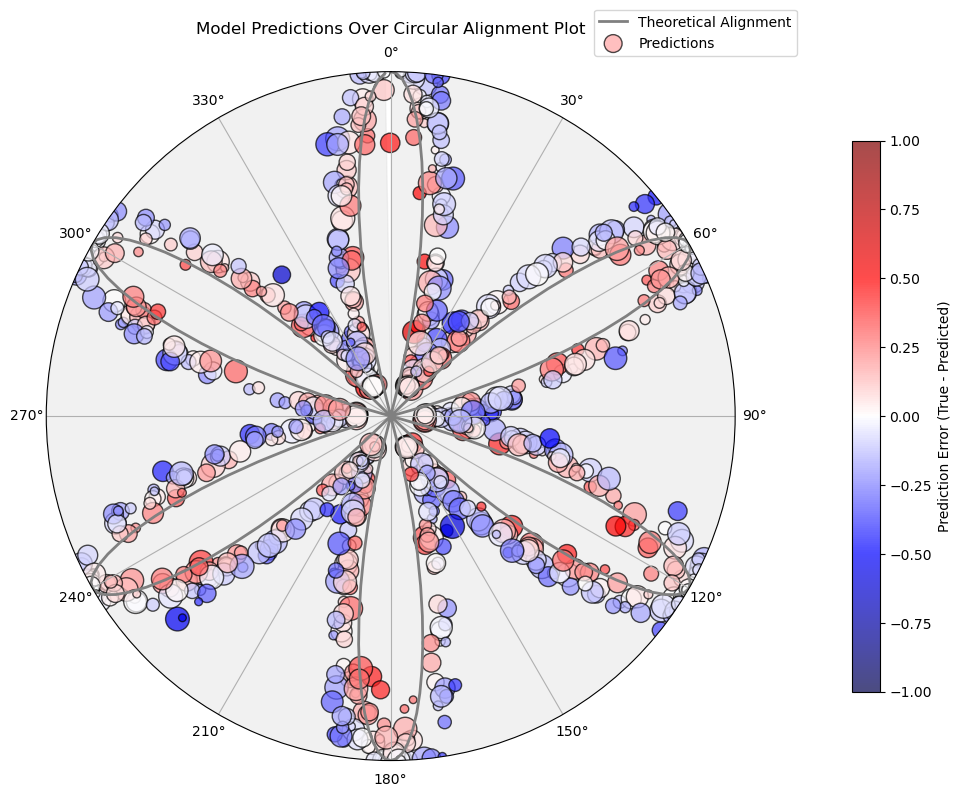

In [68]:
def compute_alignment_score(angle):
    """
    Compute the alignment score for a given orientation angle.
    The score ranges from 1 (max alignment) to -1 (max misalignment).
    """
    # Aligned angles at every 60 degrees
    aligned_angles = np.arange(0, 360, 60)
    angle_mod = angle % 360

    # Compute minimal angular difference to nearest aligned angle
    angle_diff = np.abs(aligned_angles - angle_mod)
    angle_diff = np.minimum(angle_diff, 360 - angle_diff)
    min_diff = np.min(angle_diff)

    # Adjust min_diff to be within 0° to 30°
    min_diff = min_diff % 60
    if min_diff > 30:
        min_diff = 60 - min_diff

    # Compute alignment score using cosine function
    alignment_score = np.cos(np.deg2rad((180 / 30) * min_diff))
    return alignment_score

def load_delay_data(input_dir, prefixes, required_columns, voxel_indices=None,
                    seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5):
    """
    Load and process data for multiple file pairs.
    """
    data_x_list = []
    data_y_list = []
    scalers = []
    labels_list = []
    id_list = []

    matched_files = match_files(input_dir, prefixes)
    print(f"\nTotal matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice
    delay_rows = int(delay_seconds / seconds_per_row)
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Extract participant_id and run_id from the prefix
            prefix = os.path.splitext(os.path.basename(nifti_path))[0]
            participant_id, run_id = prefix.split('_')

            # Load and process data
            df, voxel_list = get_measurement_df(
                nifti_path=nifti_path,
                csv_path=csv_path,
                required_columns=required_columns,
                rows_per_slice=rows_per_slice,
                delay_rows=delay_rows,
                voxel_indices=voxel_indices
            )

            if df is None:
                print(f"  Skipping file pair due to previous errors.\n")
                continue

            # Prepare the features
            voxel_list = [col for col in df.columns if col.startswith('voxel_')]
            features = df[voxel_list].values
            scaler_features = MinMaxScaler()
            features_scaled = scaler_features.fit_transform(features)

            # Reshape features for 1D CNN input
            num_samples, num_voxels = features_scaled.shape
            features_reshaped = features_scaled.reshape(num_samples, num_voxels, 1)
            data_x = features_reshaped.astype(np.float32)

            # Prepare the labels (alignment scores)
            df['Alignment_Score'] = df['Orientation'].apply(compute_alignment_score)
            target = df['Alignment_Score'].values.astype(np.float32)
            data_y = target  # For regression

            # Append to lists
            data_x_list.append(data_x)
            data_y_list.append(data_y)
            labels_list.append(df[['Orientation', 'Alignment_Score'] + voxel_list])
            id_list.append((participant_id, run_id))

            # Store the scaler
            scalers.append(scaler_features)

            # Debugging Information
            print(f"  Feature matrix 'data_x' shape: {data_x.shape}")
            print(f"  Target vector 'data_y' shape: {data_y.shape}")
            print(f"  Alignment scores range: {data_y.min()} to {data_y.max()}\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")
            continue

    return data_x_list, data_y_list, scalers, labels_list, id_list

def main():
    """
    Main function to execute the data processing workflow and visualize results.
    """
    # Define the data directory
    DATA_DIR = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR'

    # Generate run prefixes
    prefixes = get_run_prefixes()

    # Define required columns in CSV
    required_columns = {'Orientation', 'Time'}  # Adjust based on your CSV structure

    # Define delay parameters
    seconds_per_slice = 1.5
    rows_per_slice = 14
    delay_seconds = 7.5

    voxel_indices = None  # Use all voxels or specify indices

    # Load and process data
    data_x_list, data_y_list, scalers, labels_list, id_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        voxel_indices=voxel_indices,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds
    )

    # Combine data from all runs
    data_x = np.concatenate(data_x_list, axis=0)
    data_y = np.concatenate(data_y_list, axis=0)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        data_x, data_y, test_size=0.2, random_state=42
    )

    # Define the model
    num_voxels = data_x.shape[1]
    input_shape = (num_voxels, 1)
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1)  # Regression output
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=16
    )

    # Evaluate the model
    loss, mae, mse = model.evaluate(X_val, y_val)
    print(f"Validation Loss (MSE): {loss:.4f}, Validation MAE: {mae:.4f}, Validation MSE: {mse:.4f}")

    # Predictions
    y_pred = model.predict(X_val).flatten()

    # Visualize True vs Predicted Alignment Scores
    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, y_pred, alpha=0.6)
    plt.plot([-1, 1], [-1, 1], 'r--', label='Ideal Fit')
    plt.xlabel('True Alignment Score')
    plt.ylabel('Predicted Alignment Score')
    plt.title('True vs Predicted Alignment Scores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the Alignment Score Function
    angles = np.linspace(0, 360, 720)
    alignment_scores = np.array([compute_alignment_score(angle) for angle in angles])

    plt.figure(figsize=(12, 4))
    plt.plot(angles, alignment_scores, label='Alignment Score')
    plt.title('Alignment Score vs. Orientation Angle')
    plt.xlabel('Orientation Angle (degrees)')
    plt.ylabel('Alignment Score')
    plt.xticks(np.arange(0, 361, 30))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    def plot_training_history(history):
        # Extract loss and metrics from the history object
        mae = history.history['mae']
        val_mae = history.history['val_mae']
        mse = history.history['mse']
        val_mse = history.history['val_mse']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)

        # Plot MAE
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, mae, 'bo-', label='Training MAE')
        plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Error')
        plt.legend()

        # Plot MSE
        plt.subplot(1, 2, 2)
        plt.plot(epochs, mse, 'bo-', label='Training MSE')
        plt.plot(epochs, val_mse, 'ro-', label='Validation MSE')
        plt.title('Training and Validation MSE')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    plot_training_history(history)

    def visualize_predictions_circularA(y_pred, y_true, orientation_angles):
        """
        Visualize model predictions over a circular plot representing the cyclical alignment.

        Args:
            y_pred (numpy.ndarray): Predicted alignment scores.
            y_true (numpy.ndarray): True alignment scores.
            orientation_angles (numpy.ndarray): Corresponding orientation angles in degrees.
        """
        # Normalize predicted alignment scores to [0, 1] for plotting radii
        scaler_radius = MinMaxScaler(feature_range=(0.2, 1))  # Avoid radius = 0
        radii = scaler_radius.fit_transform(y_pred.reshape(-1, 1)).flatten()
        
        # Normalize prediction errors for color mapping
        prediction_errors = y_true - y_pred
        scaler_color = Normalize(vmin=-1, vmax=1)
        colors = plt.cm.seismic(scaler_color(prediction_errors))
        
        # Prepare the base circular plot
        num_points = 360
        angles_full = np.deg2rad(np.linspace(0, 360, num_points, endpoint=False))
        alignment_scores_full = np.array([compute_alignment_score(np.rad2deg(angle)) for angle in angles_full])
        
        # Create a figure and a polar subplot
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 8))
        
        # Plot the base alignment scores as a filled area
        ax.fill_between(angles_full, 0, 1, color='lightgray', alpha=0.3)
        
        # Plot the alignment score curve
        ax.plot(angles_full, (alignment_scores_full + 1) / 2, color='gray', linewidth=2, label='Theoretical Alignment')
        
        # Overlay model predictions
        # Convert orientation angles to radians
        angles_pred = np.deg2rad(orientation_angles % 360)
        
        # Plot predictions with markers
        scatter = ax.scatter(angles_pred, radii, c=prediction_errors, cmap='seismic', norm=scaler_color,
                            s=50, alpha=0.7, edgecolors='k', label='Predictions')
        
        # Add a color bar for prediction errors
        cbar = fig.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
        cbar.set_label('Prediction Error (True - Predicted)')
        
        # Customize the polar plot
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_thetagrids(range(0, 360, 30), labels=[f'{i}°' for i in range(0, 360, 30)])
        ax.set_rlabel_position(180)
        ax.set_yticks([])
        ax.set_ylim(0, 1)
        ax.set_title('Model Predictions Over Circular Alignment Plot', va='bottom')
        
        # Add legend
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        
        plt.tight_layout()
        plt.show()

    # Example usage (assuming y_pred, y_true, and orientation_angles are available)
    # y_pred: Predicted alignment scores from the model
    # y_true: True alignment scores (computed using compute_alignment_score)
    # orientation_angles: True orientation angles corresponding to y_pred and y_true

    # For demonstration purposes, let's generate some sample data
    np.random.seed(42)
    num_samples = 1000
    orientation_angles = np.random.uniform(0, 360, num_samples)
    y_true = np.array([compute_alignment_score(angle) for angle in orientation_angles])

    # Simulate predictions with some noise
    y_pred = y_true + np.random.normal(0, 0.2, num_samples)
    y_pred = np.clip(y_pred, -1, 1)  # Ensure predictions are within [-1, 1]

    visualize_predictions_circularA(y_pred, y_true, orientation_angles)

    def visualize_predictions_circularB(y_pred, y_true, orientation_angles, signal_intensities):
        # Normalize predicted alignment scores to [0.1, 1] for plotting radii
        scaler_radius = MinMaxScaler(feature_range=(0.1, 1))
        radii = scaler_radius.fit_transform(y_pred.reshape(-1, 1)).flatten()

        # Calculate prediction errors
        prediction_errors = y_true - y_pred

        # Set up a normalizer and colormap for consistent coloring
        norm = Normalize(vmin=-1, vmax=1)
        cmap = plt.cm.seismic

        # Normalize signal intensities for marker sizes
        scaler_size = MinMaxScaler(feature_range=(30, 300))
        sizes = scaler_size.fit_transform(signal_intensities.reshape(-1, 1)).flatten()

        # Prepare the base circular plot
        num_points = 360
        angles_full = np.deg2rad(np.linspace(0, 360, num_points, endpoint=False))
        alignment_scores_full = [compute_alignment_score(np.rad2deg(angle)) for angle in angles_full]

        # Create a figure and a polar subplot
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 8))

        # Plot the base alignment scores as a filled area
        ax.fill_between(angles_full, 0, 1, color='lightgray', alpha=0.3)
        ax.plot(angles_full, np.array(alignment_scores_full) / max(alignment_scores_full), color='gray', linewidth=2, label='Theoretical Alignment')

        # Convert orientation angles to radians for plotting
        angles_pred = np.deg2rad(orientation_angles % 360)

        # Plot predictions with markers colored by prediction errors
        scatter = ax.scatter(angles_pred, radii, c=prediction_errors, cmap=cmap, norm=norm, s=sizes, alpha=0.7, edgecolors='k', label='Predictions')

        # Set up the colorbar with the correct normalization and colormap
        cbar = fig.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
        cbar.set_label('Prediction Error (True - Predicted)')

        # Customize the plot
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_thetagrids(range(0, 360, 30), labels=[f'{i}°' for i in range(0, 360, 30)])
        ax.set_rlabel_position(180)
        ax.set_yticks([])
        ax.set_ylim(0, 1)
        ax.set_title('Model Predictions Over Circular Alignment Plot', va='bottom')
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

        plt.tight_layout()
        plt.show()

    # Simulated data for demonstration
    np.random.seed(42)
    num_samples = 1000
    orientation_angles = np.random.uniform(0, 360, num_samples)
    signal_intensities = np.random.rand(num_samples)  # Simulated signal intensities
    y_true = np.array([compute_alignment_score(angle) for angle in orientation_angles])
    y_pred = y_true + np.random.normal(0, 0.2, num_samples)  # Simulate predictions with some noise
    y_pred = np.clip(y_pred, -1, 1)  # Ensure predictions are within [-1, 1]

    visualize_predictions_circularB(y_pred, y_true, orientation_angles, signal_intensities)

if __name__ == "__main__":
    main()


CNN-RNN

Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run006.ni

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.5483 - mae: 0.6631 - mse: 0.5483 - val_loss: 0.5437 - val_mae: 0.6650 - val_mse: 0.5437
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5301 - mae: 0.6528 - mse: 0.5301 - val_loss: 0.5428 - val_mae: 0.6644 - val_mse: 0.5428
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5303 - mae: 0.6529 - mse: 0.5303 - val_loss: 0.5467 - val_mae: 0.6670 - val_mse: 0.5467
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5297 - mae: 0.6529 - mse: 0.5297 - val_loss: 0.5412 - val_mae: 0.6624 - val_mse: 0.5412
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5308 - mae: 0.6529 - mse: 0.5308 - val_loss: 0.5447 - val_mae: 0.6658 - val_mse: 0.5447
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5297 - mae: 0.6527 - mse: 0.5297 - val_loss: 0.5457 - val_mae: 0.6663 - val_mse: 0.5457
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5292 - mae: 0.6525 - mse: 0.5292 - val_loss: 

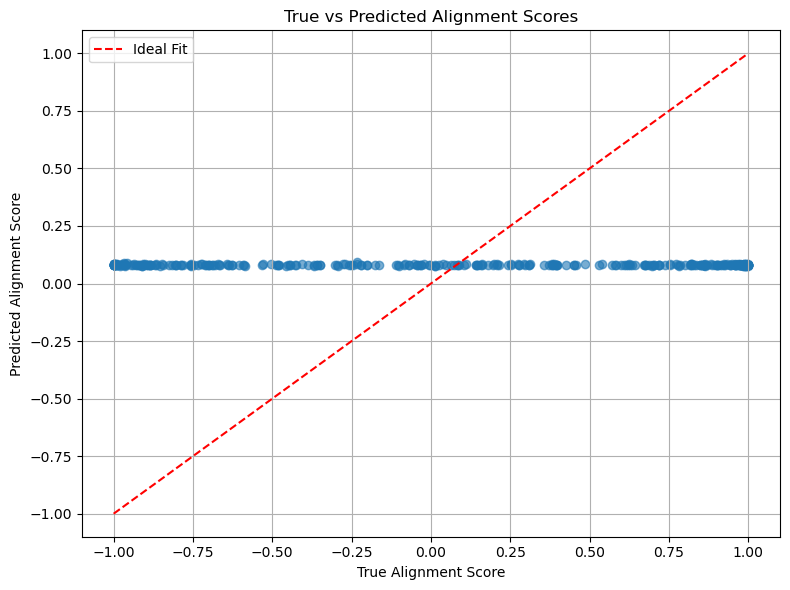

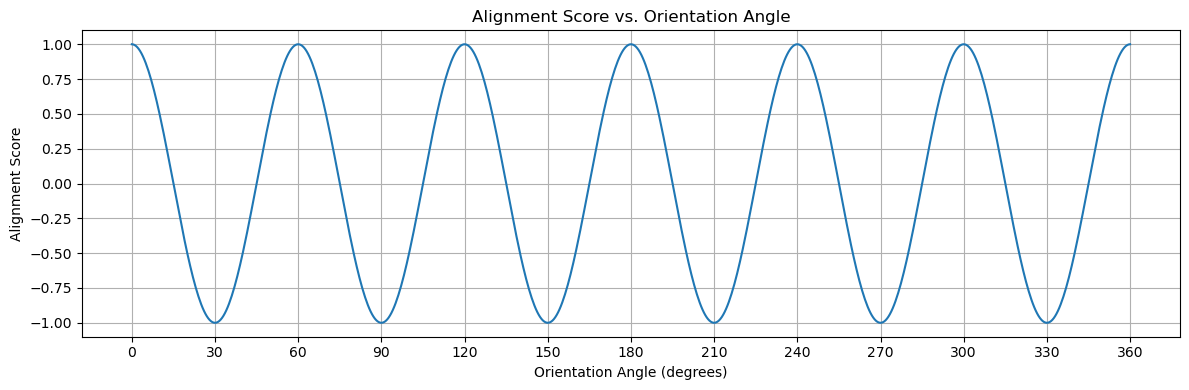

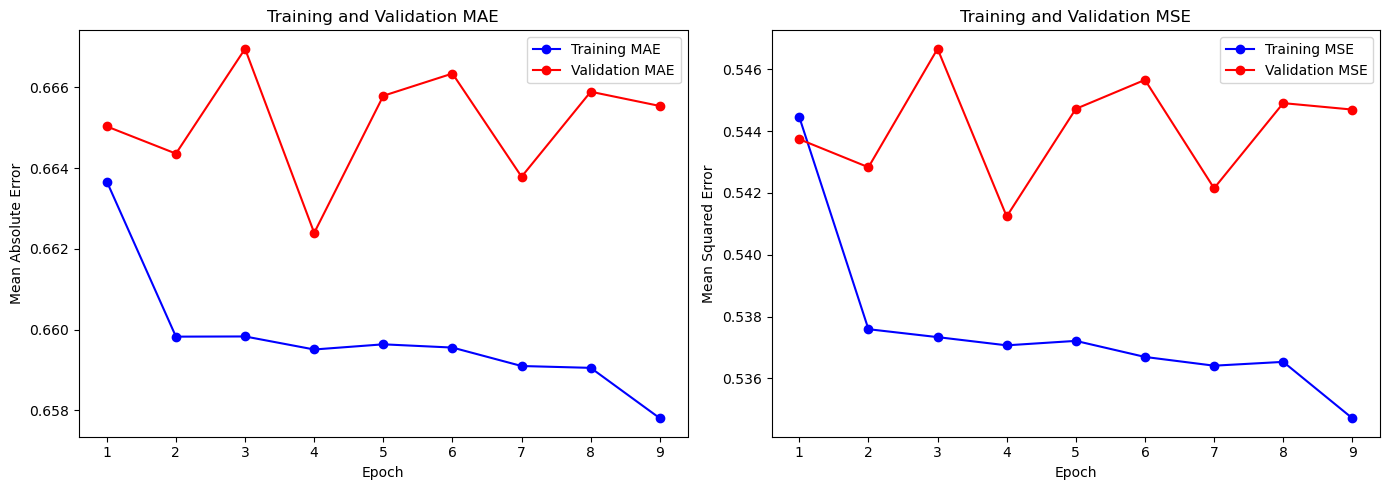

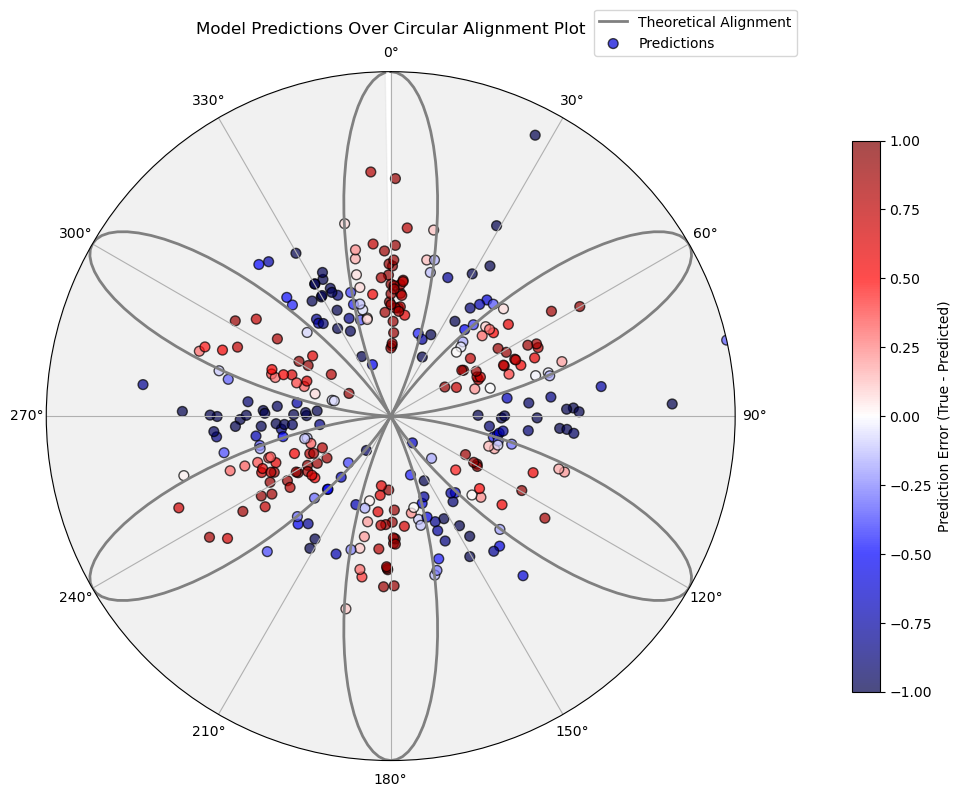

Data processing and regression complete.


In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.colors import Normalize

def compute_alignment_score(angle):
    """
    Compute the alignment score for a given orientation angle.
    The score ranges from 1 (max alignment) to -1 (max misalignment).
    """
    # Aligned angles at every 60 degrees
    aligned_angles = np.arange(0, 360, 60)
    angle_mod = angle % 360

    # Compute minimal angular difference to nearest aligned angle
    angle_diff = np.abs(aligned_angles - angle_mod)
    angle_diff = np.minimum(angle_diff, 360 - angle_diff)
    min_diff = np.min(angle_diff)

    # Adjust min_diff to be within 0° to 30°
    min_diff = min_diff % 60
    if min_diff > 30:
        min_diff = 60 - min_diff

    # Compute alignment score using cosine function
    alignment_score = np.cos(np.deg2rad((180 / 30) * min_diff))
    return alignment_score

def create_sequences(data_x, data_y, data_orientations, time_steps):
    sequences_x = []
    sequences_y = []
    sequences_orientations = []
    for i in range(len(data_x) - time_steps + 1):
        seq_x = data_x[i:i + time_steps]
        seq_y = data_y[i + time_steps - 1]
        seq_orientation = data_orientations[i + time_steps - 1]
        sequences_x.append(seq_x)
        sequences_y.append(seq_y)
        sequences_orientations.append(seq_orientation)
    return np.array(sequences_x), np.array(sequences_y), np.array(sequences_orientations)

def load_delay_data(input_dir, prefixes, required_columns, voxel_indices=None,
                    seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5):
    """
    Load and process data for multiple file pairs.
    """
    data_x_list = []
    data_y_list = []
    data_orientations_list = []  # Initialize orientations list
    scalers = []
    labels_list = []
    id_list = []

    matched_files = match_files(input_dir, prefixes)
    print(f"\nTotal matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice
    delay_rows = int(delay_seconds / seconds_per_row)
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Extract participant_id and run_id from the prefix
            prefix = os.path.splitext(os.path.basename(nifti_path))[0]
            participant_id, run_id = prefix.split('_')

            # Load and process data
            df, voxel_list = get_measurement_df(
                nifti_path=nifti_path,
                csv_path=csv_path,
                required_columns=required_columns,
                rows_per_slice=rows_per_slice,
                delay_rows=delay_rows,
                voxel_indices=voxel_indices
            )

            if df is None:
                print(f"  Skipping file pair due to previous errors.\n")
                continue

            # Prepare the features
            voxel_list = [col for col in df.columns if col.startswith('voxel_')]
            features = df[voxel_list].values
            scaler_features = MinMaxScaler()
            features_scaled = scaler_features.fit_transform(features)

            # Prepare the labels (alignment scores)
            df['Alignment_Score'] = df['Orientation'].apply(compute_alignment_score)
            target = df['Alignment_Score'].values.astype(np.float32)
            data_y = target  # For regression

            # Prepare orientations
            data_orientations = df['Orientation'].values.astype(np.float32)

            # Append to lists
            data_x_list.append(features_scaled)
            data_y_list.append(data_y)
            data_orientations_list.append(data_orientations)  # Append orientations
            labels_list.append(df[['Orientation', 'Alignment_Score'] + voxel_list])
            id_list.append((participant_id, run_id))

            # Store the scaler
            scalers.append(scaler_features)

            # Debugging Information
            print(f"  Feature matrix 'features_scaled' shape: {features_scaled.shape}")
            print(f"  Target vector 'data_y' shape: {data_y.shape}")
            print(f"  Alignment scores range: {data_y.min()} to {data_y.max()}\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")
            continue

    return data_x_list, data_y_list, data_orientations_list, scalers, labels_list, id_list

def plot_training_history(history):
    # Extract loss and metrics from the history object
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Plot MAE
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae, 'bo-', label='Training MAE')
    plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    # Plot MSE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mse, 'bo-', label='Training MSE')
    plt.plot(epochs, val_mse, 'ro-', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions_circular(y_pred, y_true, orientation_angles, signal_intensities=None):
    """
    Visualize model predictions over a circular plot representing the cyclical alignment.

    Args:
        y_pred (numpy.ndarray): Predicted alignment scores.
        y_true (numpy.ndarray): True alignment scores.
        orientation_angles (numpy.ndarray): Corresponding orientation angles in degrees.
        signal_intensities (numpy.ndarray): Optional, used to adjust marker sizes.
    """
    # Normalize predicted alignment scores to [0.1, 1] for plotting radii
    scaler_radius = MinMaxScaler(feature_range=(0.1, 1))
    radii = scaler_radius.fit_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate prediction errors
    prediction_errors = y_true - y_pred

    # Set up a normalizer and colormap for consistent coloring
    norm = Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.seismic

    # Normalize signal intensities for marker sizes
    if signal_intensities is not None:
        scaler_size = MinMaxScaler(feature_range=(30, 300))
        sizes = scaler_size.fit_transform(signal_intensities.reshape(-1, 1)).flatten()
    else:
        sizes = 50  # Default marker size

    # Prepare the base circular plot
    num_points = 360
    angles_full = np.deg2rad(np.linspace(0, 360, num_points, endpoint=False))
    alignment_scores_full = np.array([compute_alignment_score(np.rad2deg(angle)) for angle in angles_full])

    # Create a figure and a polar subplot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 8))

    # Plot the base alignment scores as a filled area
    ax.fill_between(angles_full, 0, 1, color='lightgray', alpha=0.3)
    ax.plot(angles_full, (alignment_scores_full + 1) / 2, color='gray', linewidth=2, label='Theoretical Alignment')

    # Convert orientation angles to radians for plotting
    angles_pred = np.deg2rad(orientation_angles % 360)

    # Plot predictions with markers colored by prediction errors
    scatter = ax.scatter(angles_pred, radii, c=prediction_errors, cmap=cmap, norm=norm, s=sizes, alpha=0.7, edgecolors='k', label='Predictions')

    # Set up the colorbar with the correct normalization and colormap
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
    cbar.set_label('Prediction Error (True - Predicted)')

    # Customize the plot
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(range(0, 360, 30), labels=[f'{i}°' for i in range(0, 360, 30)])
    ax.set_rlabel_position(180)
    ax.set_yticks([])
    ax.set_ylim(0, 1)
    ax.set_title('Model Predictions Over Circular Alignment Plot', va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.tight_layout()
    plt.show()

def main():
    # Define the data directory
    DATA_DIR = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR'

    # Generate run prefixes
    prefixes = get_run_prefixes()

    # Define required columns in CSV
    required_columns = {'Orientation', 'Time'}  # Adjust based on your CSV structure

    # Define delay parameters
    seconds_per_slice = 1.5
    rows_per_slice = 14
    delay_seconds = 7.5

    voxel_indices = None  # Use all voxels or specify indices

    # Load and process data
    data_x_list, data_y_list, data_orientations_list, scalers, labels_list, id_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        voxel_indices=voxel_indices,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds
    )

    # Combine data from all runs
    data_x = np.concatenate(data_x_list, axis=0)
    data_y = np.concatenate(data_y_list, axis=0)
    data_orientations = np.concatenate(data_orientations_list, axis=0)

    # Split data
    X_train, X_val, y_train, y_val, orientations_train, orientations_val = train_test_split(
        data_x, data_y, data_orientations, test_size=0.2, random_state=42
    )

    # Create sequences
    time_steps = 10
    X_train_seq, y_train_seq, orientations_train_seq = create_sequences(
        X_train, y_train, orientations_train, time_steps)
    X_val_seq, y_val_seq, orientations_val_seq = create_sequences(
        X_val, y_val, orientations_val, time_steps)

    # Reshape input for CNN-RNN
    num_voxels = X_train_seq.shape[2]
    X_train_seq = X_train_seq.reshape(-1, time_steps, num_voxels, 1)
    X_val_seq = X_val_seq.reshape(-1, time_steps, num_voxels, 1)

    # Define the model
    input_shape = (time_steps, num_voxels, 1)
    model = Sequential([
        TimeDistributed(Conv1D(32, kernel_size=3, activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(64),
        Dense(128, activation='relu'),
        Dense(1)  # Regression output
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=16,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    loss, mae, mse = model.evaluate(X_val_seq, y_val_seq)
    print(f"Validation Loss (MSE): {loss:.4f}, Validation MAE: {mae:.4f}, Validation MSE: {mse:.4f}")

    # Predictions
    y_pred_seq = model.predict(X_val_seq).flatten()
    y_true_seq = y_val_seq
    orientation_angles_seq = orientations_val_seq  # Use the orientations from sequences

    # Visualize True vs Predicted Alignment Scores
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true_seq, y_pred_seq, alpha=0.6)
    plt.plot([-1, 1], [-1, 1], 'r--', label='Ideal Fit')
    plt.xlabel('True Alignment Score')
    plt.ylabel('Predicted Alignment Score')
    plt.title('True vs Predicted Alignment Scores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the Alignment Score Function
    angles = np.linspace(0, 360, 720)
    alignment_scores = np.array([compute_alignment_score(angle) for angle in angles])

    plt.figure(figsize=(12, 4))
    plt.plot(angles, alignment_scores, label='Alignment Score')
    plt.title('Alignment Score vs. Orientation Angle')
    plt.xlabel('Orientation Angle (degrees)')
    plt.ylabel('Alignment Score')
    plt.xticks(np.arange(0, 361, 30))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot training history
    plot_training_history(history)

    # Visualize predictions on a circular plot
    visualize_predictions_circular(y_pred_seq, y_true_seq, orientation_angles_seq)

    # Save the model
    model.save('alignment_score_prediction_model.h5')

    print("Data processing and regression complete.")

if __name__ == "__main__":
    main()


Cropping for faster processing

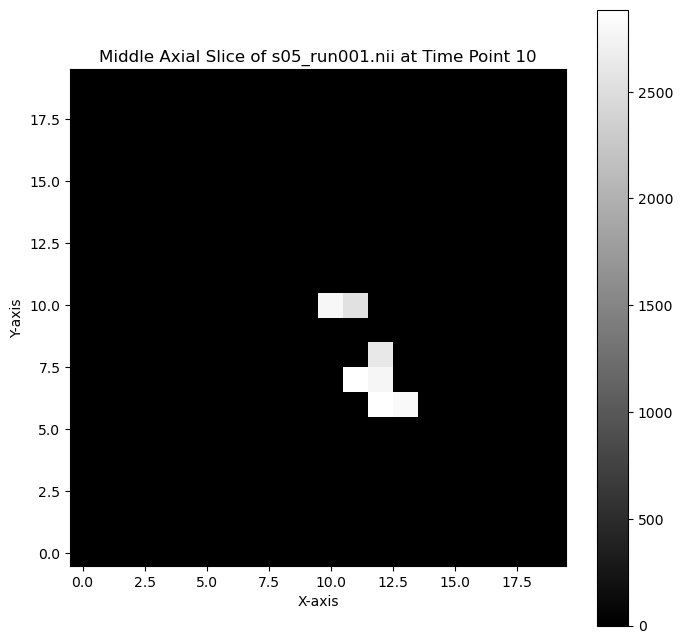

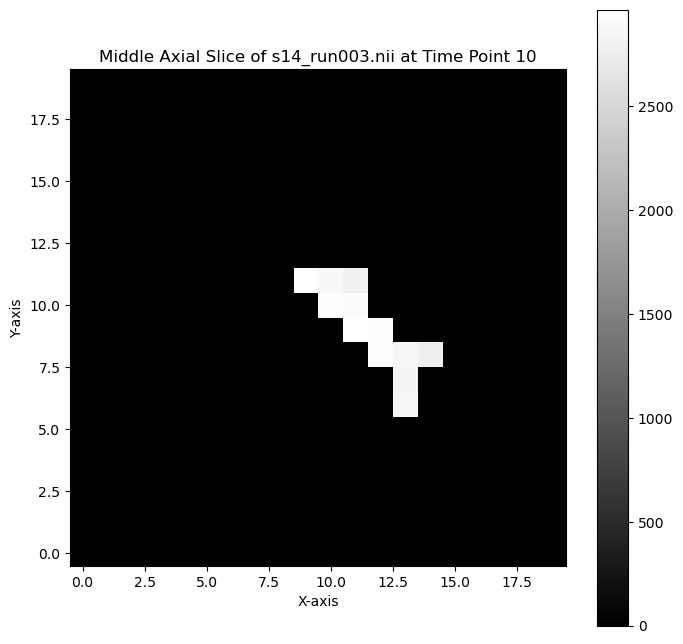

In [ ]:
def plot_nifti_with_defined_roi(file_path, time_point=6, x_bounds=(30, 50), y_bounds=(50, 70)):
    # Load the NIfTI file
    nii_img = nib.load(file_path)
    data = nii_img.get_fdata()
    
    # Extract a middle axial slice at the specified time point
    z_slice = data.shape[2] // 2  # Middle slice in the Z dimension
    slice_data = data[:, :, z_slice, time_point]
    
    # Plot the slice with the ROI highlighted
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data.T, cmap='gray', origin='lower')
    plt.colorbar()
    plt.title(f"Middle Axial Slice of {file_path.split('/')[-1]} at Time Point {time_point}")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Highlight the ROI
    rect_x, rect_y = x_bounds[0], y_bounds[0]
    rect_width = x_bounds[1] - x_bounds[0]
    rect_height = y_bounds[1] - y_bounds[0]
    plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none'))
    
    plt.show()

# Example file paths
file_path_s05 = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii'
file_path_s15 = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s14_run003.nii'

# Plot with defined ROI
plot_nifti_with_defined_roi(file_path_s05, time_point=10) 
plot_nifti_with_defined_roi(file_path_s15, time_point=10) 
